# DSCI 100: Final Project Report, Group 2

## Introduction

The PLAI group at UBC, using a MineCraft server, collected data about how people play video games through automated tracking and user-reported information. Two datasets were provided: `sessions.csv` and `players.csv`.

Understanding the characteristics of players who subscribe to game-related content is important for developers. Game-related newsletter effectively provides key details such as version updates, event schedules, and system adjustments. Subscription behavior not only reflects players' demand for information but also indicates their level of engagement and investment in the game. For developers, identifying which player groups are more willing to receive game-related content allows for more precise targeting of different groups' preferences. This helps optimise server operation strategies to attract more users. 

The goal of this analysis is to answer the question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? 

To address this broader question, this analysis will use the data in the `players.csv` dataset to answer a more specific question: **Can age and the total hours played by a player predict whether they subscribe to a game-related newsletter?**

The `players.csv` dataset contains the data necessary to answer this specific question, formatted already into a table such that the explanatory variables, `played_hours` and `Age`, are in their own columns and can be analyzed to see if they can predict the response variable, `subscribe` (whether or not the player subscribes to the game-related newsletter). Each player is one observation in this dataset, so we can compare these variables for each player and see if the explanatory variables are good predictors.  

By determining whether `Age` and `played_hours` can predict subscription status, we can identify which player characteristics and behaviours are most closely associated with engagement in game-related content.


**For flow, the code to load and observe the dataset and calculate summary statistics is written in the Methods section. This section is only for descriptions of data derived from the code output from Methods.**

#### `players.csv` Overview

The `players.csv` dataset provides information about each player. There are 196 observations and the dataset contains 7 variables:

| Variable | Data type | Meaning | Variable details |
| :------- | :------- | :------- | :------- |
| experience | Character | Experience level of the player | Pro/Veteran/Amateur/Regular/Beginner |
| subscribe | Logical | Whether the player subscribed to a game-related newsletter | True/False |
| hashedEmail | Character | Anonymized identifier for each player's email | - |
| played_hours | Double (Numeric) | Total time spent playing for each player in hours | - |
| name | Character | Player name | - |
| gender | Character | Player gender | Male/Female/Non-binary/Prefer not to say/Agender/Two-Spirit/Other |
| Age | Double (Numeric) | Player age in years | - |

Potential problems in this dataset are:
- The values in the `subscribe` variable column are of the logical data type, and are not very descriptive of what the data means. They could be changed to factor type and renamed to describe the status of a player's subscription.
- There are missing (NA) values for some observations in the `Age` variable; these need to be dealt with prior to gathering summary statistics.
- It's not clear how the data was collected, such as how player experience was gauged (self-reported? Other testing metrics?).
- `name` is not necessary, especially with `hashedEmail` as an identifier.

#### Summary Statistics for `players.csv` Dataset

The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. 

| Variable | Mean | Min | Max |
| :------- | :------- | :------- | :------- |
| Age (years) | 21.14 | 9 | 58 |
| Hours played per player | 5.90 | 0 | 223.1 |

## Methods & Results

#### Load Libraries and Data

The first step is to load libraries and read in the dataset so that we can observe the dataset, obtain summary statistics, and describe it. **Descriptions and summary statistics obtained from this analysis are reported in the Introduction.**

In [1]:
#Loading libraries

library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Reading in data from the players dataset

players_url <- "https://drive.google.com/uc?export=download&id=1wPawgc5uTyx2Btw3NTQR8VPvyRDrLwqT"

players_data <- read_csv(players_url)
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### Tidying Data

The data now must be wrangled and tidied so that it is ready for analysis. To do this, we remove the rows with NA and convert the columns into the appropriate data type. In the `subscribe` column, `FALSE` and `TRUE` values were changed to `Unsubscribed` and `Subscribed` to make this more descriptive.

In [3]:
#Tidying data: removing rows with NA, converting to correct data types, and changing to descriptive names

players_data <- players_data |>
                filter(!is.na(Age), !is.na(played_hours), !is.na(subscribe)) |>
                mutate(subscribe = as.factor(subscribe),
                       subscribe = recode(subscribe, "FALSE" = "Unsubscribed", "TRUE" = "Subscribed"))
players_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Unsubscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,Unsubscribed,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,Unsubscribed,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,Unsubscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


#### Summary Statistics Calculations

The next step is to perform a summary of the data for exploratory analysis.

In [4]:
#Players dataset: Max, Min, and Mean for each quantitative variable
player_max<- players_data |>
summarize(across(c(played_hours,Age),~round(max(.x, na.rm=TRUE),2)),statistic = "max")

player_min<- players_data|>
summarize(across(c(played_hours,Age),~round(min(.x, na.rm=TRUE),2)),statistic = "min")

player_mean<- players_data|>
summarize(across(c(played_hours,Age),~round(mean(.x, na.rm=TRUE),2)),statistic = "mean")

player_stats <- bind_rows(player_max,player_min,player_mean)

player_stats

played_hours,Age,statistic
<dbl>,<dbl>,<chr>
223.1,58.00,max
0.0,9.00,min
5.9,21.14,mean


The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. This is also reported in a table in the Introduction.

In [5]:
subscribe_frequency <- players_data|>
count(subscribe)|>
mutate(percent = n/sum(n) *100)|>
arrange(desc(n))
subscribe_frequency

subscribe,n,percent
<fct>,<int>,<dbl>
Subscribed,142,73.19588
Unsubscribed,52,26.80412


The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. This is also reported in a table in the Introduction.

#### Exploratory Visualizations

As part of exploratory analysis, we will create a visualization to explore potential relationships between subscription status of players based on their age and total hours played.

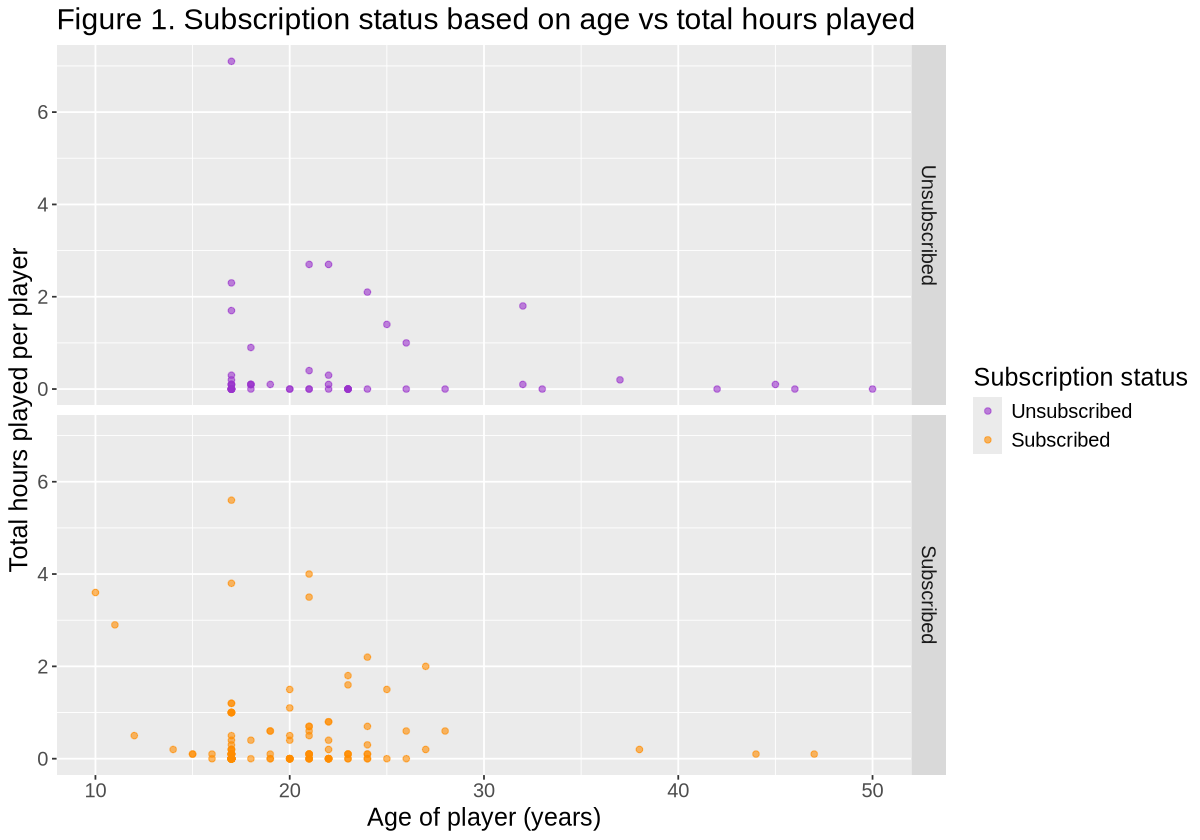

In [6]:
options(repr.plot.width = 10)

age_vs_played_hours <- players_data |>
    filter(played_hours <= 10 & Age <= 50)|> #Eliminate the influence of outliers
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age of player (years)",
         y = "Total hours played per player",
         title = "Figure 1. Subscription status based on age vs total hours played",
         color = "Subscription status") +
    scale_color_manual(values = c("Unsubscribed" = "darkorchid", "Subscribed" = "darkorange")) +
    theme(text = element_text(size = 15))+
    facet_grid(rows=vars(subscribe)) #Split into two subgraphs by subscription status
age_vs_played_hours

This scatterplot indicates that there is no relationship between age and total hours played. 

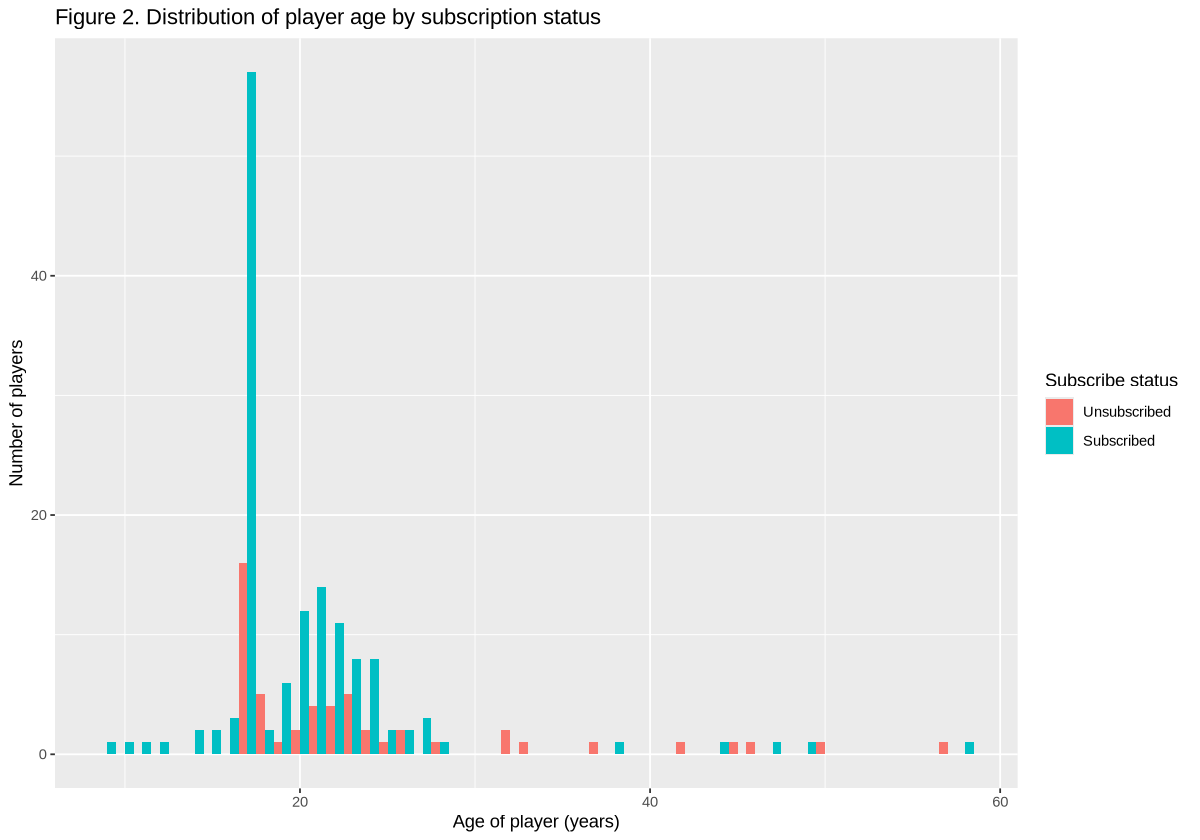

In [28]:
age_vs_subscribe <- players_data|>
ggplot(aes(x=Age, fill=subscribe))+
geom_histogram(binwidth=1,position="dodge")+
labs(x="Age of player (years)", y="Number of players",fill="Subscribe status")+
ggtitle("Figure 2. Distribution of player age by subscription status")
age_vs_subscribe

The age of subscribed players is concentrated around 20 years old, and the number of subscribed players in this age range is significantly larger than that of unsubscribed players. In contrast, the age distribution of unsubscribed players is more dispersed.

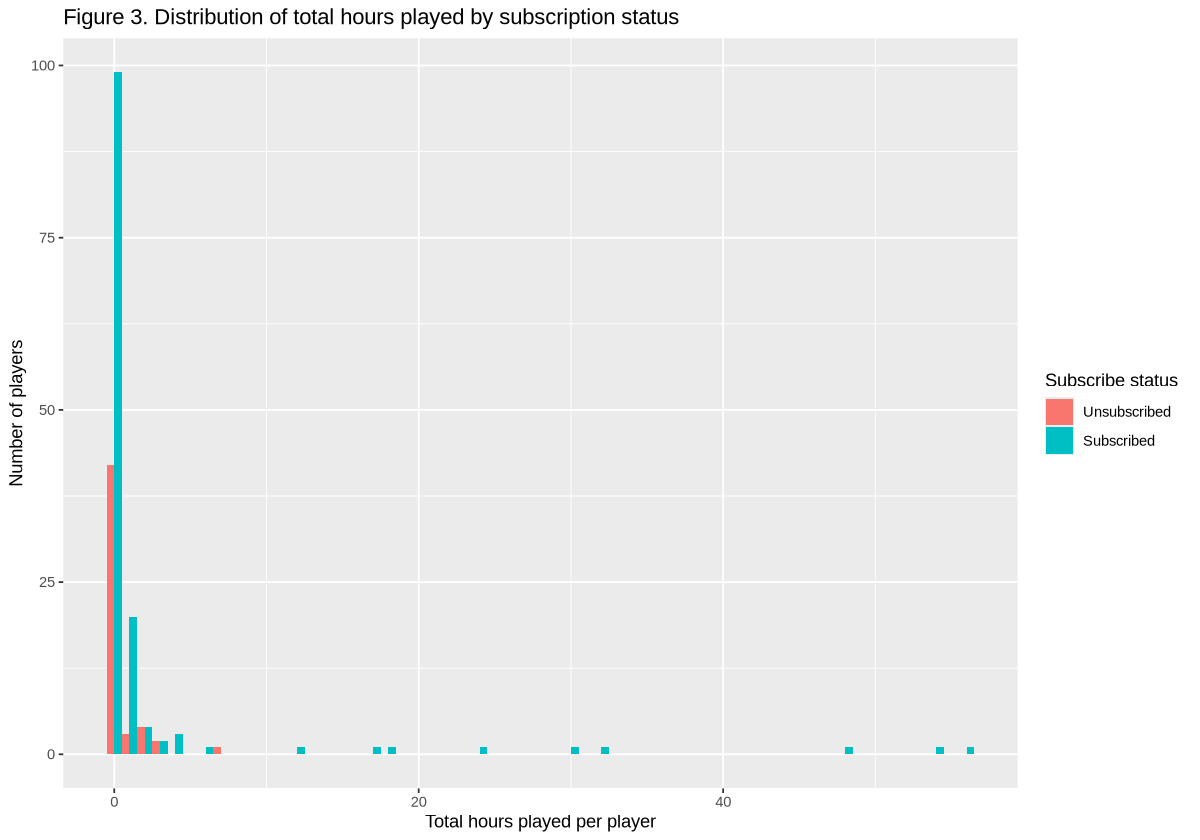

In [29]:
played_hours_vs_subscribe <- players_data|>
filter(played_hours<=60)|> #Eliminate the influence of outliers
ggplot(aes(x=played_hours, fill=subscribe))+
geom_histogram(binwidth=1,position="dodge")+
labs(x="Total hours played per player", y="Number of players",fill="Subscribe status")+
ggtitle("Figure 3. Distribution of total hours played by subscription status")
played_hours_vs_subscribe

Both subscribed and non-subscribed players' total played hours are concentrated between 0 and 5 hours, but the number of subscribed players in this time range is significantly larger than that of unsubscribed players.

Most users have not played more than 50 hours, but of the ones that do, all have subscribed. Individuals that have played a lot of hours tend to be subscribed and also younger -- no one over the age of 30 has played more than 25 hours. These, especially hours played, are therefore potential predictors for subscription status.

#### Data Analysis

We are using K-nearest neighbors classification (a supervised task) on the `players.csv` dataset, as we are using two predictors (`Age` and `hours_played`) to predict a categorical response variable (`subscribe`, which is player subscription status). 

Steps for data analysis:
1. **Dataset preparation**  
   We cleaned the `players.csv` dataset by removing rows with missing values in `Age` and standardizing the `Age` and `played_hours` variables.
2. **Split the cleaned data**  
   The dataset was split into training and testing sets by setting a 75-25% split, respectively. The training dataset was used to train the model, and the testing dataset was reserved to evaluate the performance on unseen data.
3. **Preprocessing**  
   We created a recipe to scale the `Age` and `played_hours` predictors, then built a KNN classifier and fit it to the training set.
5. **Cross-validation**  
   To select the optimal number of nearest neighbors (k), we used 5-fold cross-validation on the training set.
   We tested k values ranging from 1 to 20 and selected the k with the highest prediction accuracy.
6. **Evaluation**  
   We retrained the model using the optimal k on the full training set and evaluated its performance on the testing set to measure prediction accuracy. 

[1] 5

              Truth
Prediction     Unsubscribed Subscribed
  Unsubscribed            5          4
  Subscribed              8         32

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


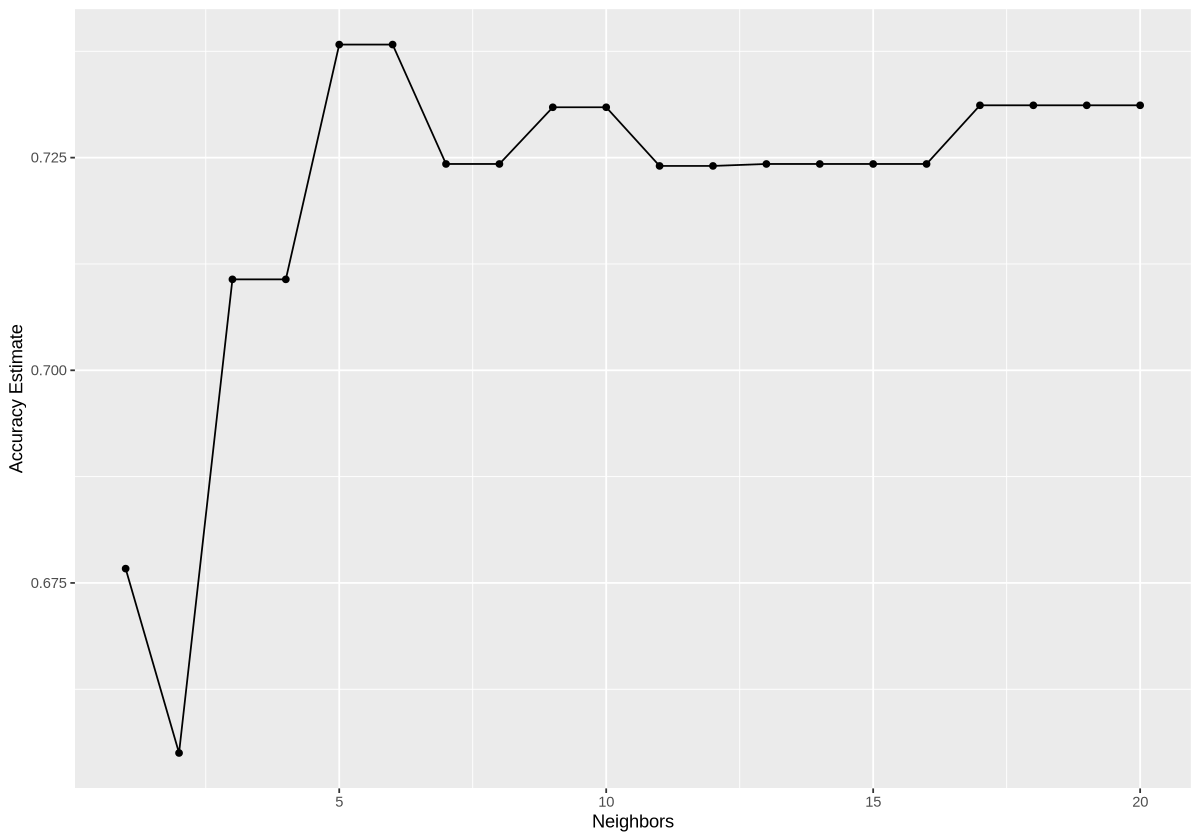

In [11]:

#Step 1: Clean and standardize.
players_data_scaled <- players_data |> 
mutate(scaled_played_hours = scale(played_hours, center = TRUE), 
       scaled_age = scale(Age, center = TRUE)) |>
select(subscribe, played_hours, Age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()

#Step 2: Splitting Data. (((((Im not sure if we use players_data_scaled or just regular data!! I used scaled but please change if you think so.)))))
players_split <- initial_split(players_data_scaled, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#Step 3: Preprocessing.
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

#Step 4: Cross-Validation.
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy") |>
      select(neighbors, mean)

best_k <- accuracies |> 
    arrange(desc(mean)) |>
    head(1) |> 
    pull(neighbors)
best_k

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k
#Step 5: Evaluation:

#New model with the best K.
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
set_engine("kknn") |>
set_mode("classification")

players_fit <- workflow() |>
add_recipe(players_recipe) |>
add_model(players_spec) |>
fit(data = players_train)

player_predictions <- predict(players_fit, new_data = players_test) |>
    bind_cols(players_test)

#Creating a confusion matric to show the predictions of the test dataset.
conf_mat <- conf_mat(player_predictions, truth = subscribe, estimate = .pred_class)
conf_mat

#Using new model to predice accuracy of the test dataset.
player_metrics <- player_predictions |>
metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")
player_metrics

#### Visualization of Analysis

TO BE WORKED ON

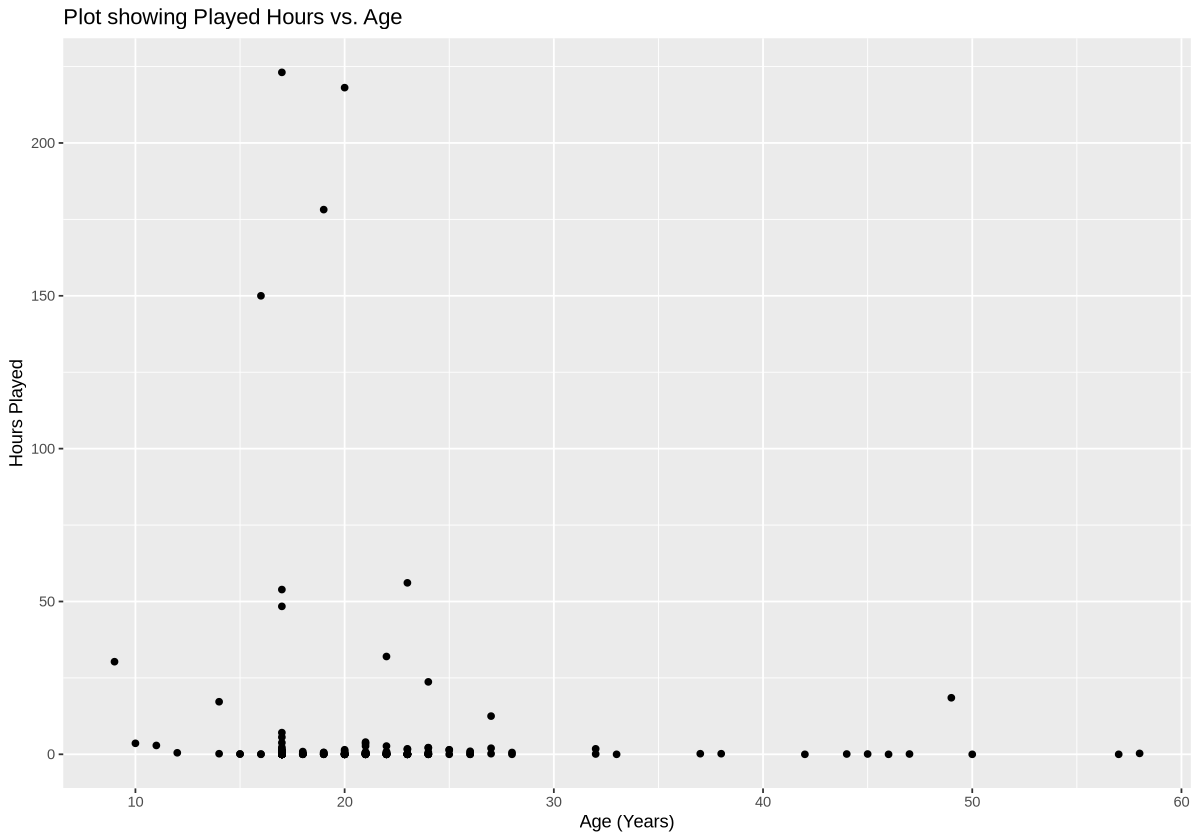

In [10]:
# I am not 100% sure if this is where I'm supposed to put this hopefully its ok
age_vs_hours_plot <- players_data_scaled |>
                     ggplot(aes(x = Age, y = played_hours)) +  
                     geom_point() +                           
                     labs(title = "Plot showing Played Hours vs. Age", x = "Age (Years)", y = "Hours Played")
age_vs_hours_plot

In [14]:
plot_data<- player_predictions |>
rename(predicted_subscribe = .pred_class,
       true_subscribe=subscribe)|>
select(Age, played_hours, true_subscribe, predicted_subscribe)
plot_data

Age,played_hours,true_subscribe,predicted_subscribe
<dbl>,<dbl>,<fct>,<fct>
22,0,Subscribed,Subscribed
17,0,Subscribed,Subscribed
23,0,Unsubscribed,Unsubscribed
⋮,⋮,⋮,⋮
24,2.1,Unsubscribed,Subscribed
22,32.0,Subscribed,Subscribed
44,0.1,Subscribed,Unsubscribed


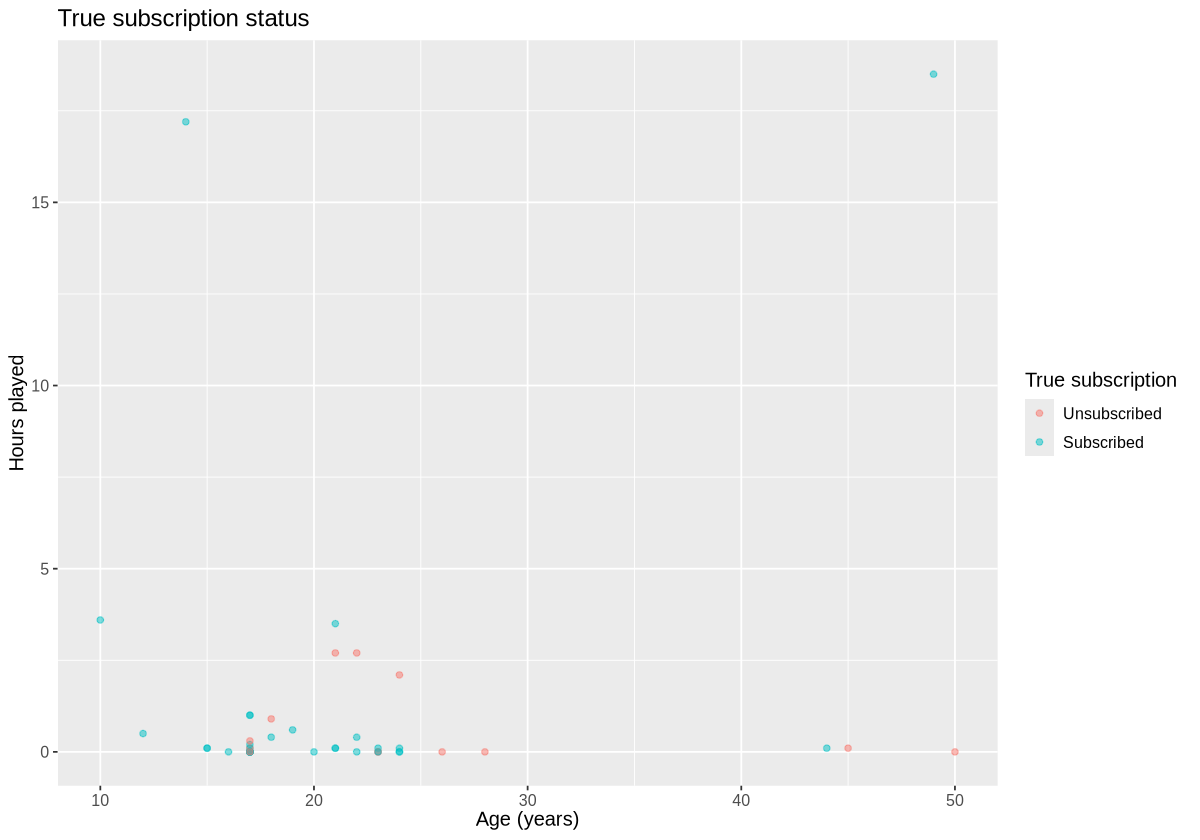

In [30]:
true_plot <- plot_data|>
filter(played_hours<=25)|>
ggplot(aes(x=Age,y=played_hours,color=true_subscribe))+
geom_point(alpha=0.5)+
labs(x="Age (years)", y="Hours played", color="True subscription")+
ggtitle("True subscription status")+
theme(text=element_text(size=12))
true_plot

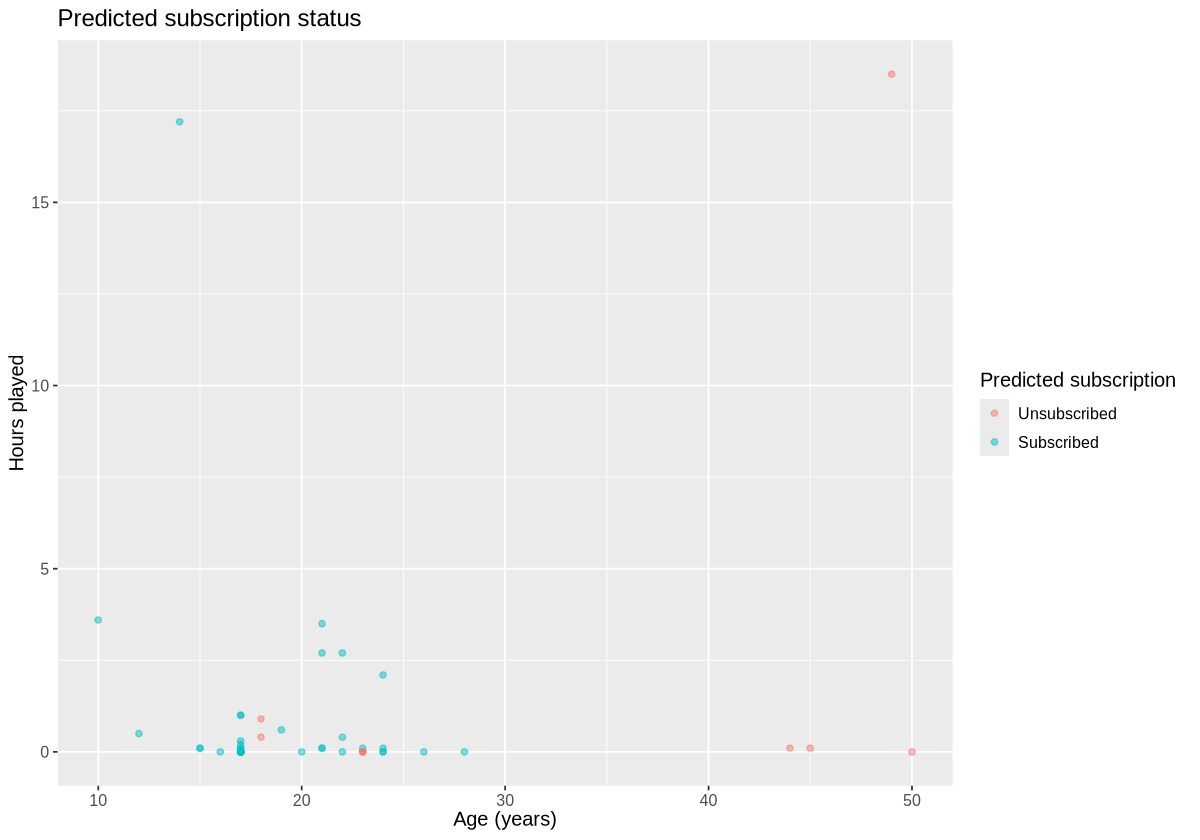

In [32]:
pred_plot <- plot_data|>
filter(played_hours<= 25)|>
ggplot(aes(x=Age,y=played_hours,color=predicted_subscribe))+
geom_point(alpha=0.5)+
labs(x="Age (years)", y="Hours played", color="Predicted subscription")+
ggtitle("Predicted subscription status")+
theme(text=element_text(size=12))
pred_plot

## Discussion

TO BE WORKED ON. The following must be added:

- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## References

- You may include references if necessary, as long as they all have a consistent citation style.